<h1>Analysis of political programs for General Election in Spain (April 28th, 2019)<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Motivation" data-toc-modified-id="Motivation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Motivation</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data loading</a></span><ul class="toc-item"><li><span><a href="#Data-sources" data-toc-modified-id="Data-sources-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data sources</a></span></li><li><span><a href="#Functions-for-web-scrapping" data-toc-modified-id="Functions-for-web-scrapping-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Functions for web scrapping</a></span></li><li><span><a href="#Functions-for-PDF-parsing" data-toc-modified-id="Functions-for-PDF-parsing-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Functions for PDF parsing</a></span></li><li><span><a href="#Functions-for-Excel-parsing" data-toc-modified-id="Functions-for-Excel-parsing-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Functions for Excel parsing</a></span></li><li><span><a href="#Load-control" data-toc-modified-id="Load-control-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Load control</a></span></li></ul></li><li><span><a href="#Obtaining-and-preprocessing-the-text" data-toc-modified-id="Obtaining-and-preprocessing-the-text-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Obtaining and preprocessing the text</a></span><ul class="toc-item"><li><span><a href="#Stop-words" data-toc-modified-id="Stop-words-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Stop words</a></span></li></ul></li><li><span><a href="#Word-clouds" data-toc-modified-id="Word-clouds-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Word clouds</a></span><ul class="toc-item"><li><span><a href="#Word-clouds-by-frequency" data-toc-modified-id="Word-clouds-by-frequency-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Word clouds by frequency</a></span></li></ul></li><li><span><a href="#Concerns-of-the-spanish-voters" data-toc-modified-id="Concerns-of-the-spanish-voters-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Concerns of the spanish voters</a></span><ul class="toc-item"><li><span><a href="#CIS-survey" data-toc-modified-id="CIS-survey-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>CIS survey</a></span></li><li><span><a href="#Reflection-in-the-electoral-programs" data-toc-modified-id="Reflection-in-the-electoral-programs-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Reflection in the electoral programs</a></span></li></ul></li><li><span><a href="#More-problems!" data-toc-modified-id="More-problems!-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>More problems!</a></span></li><li><span><a href="#Future-lines-of-work" data-toc-modified-id="Future-lines-of-work-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Future lines of work</a></span></li><li><span><a href="#References" data-toc-modified-id="References-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Motivation

We are in the last days of the electoral campaign prior to the General Election in Spain, and the political parties try to convince the indecisive few, using all of their weapons. If we move away from the debates, from the meetings in large venues, from the messages thrown in social networks, and the interviews granted to the media, we are left with what should be the most important thing: their programs.

In this notebook we will analyze some aspects of the electoral programs of the main Spanish parties in terms of voting intention (according to the latest surveys conducted).

NOTE: No one has read any program around here.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import string
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multidict as multidict
import plotly_express as px
import nltk

from bs4 import BeautifulSoup as bso
from os import path
from tika import parser, config
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from stop_words import get_stop_words
from googletrans import Translator

In [3]:
%matplotlib inline
sns.set()

# Data loading

## Data sources

**Electoral programs**:
* [PSOE](https://www.psoe.es/programa-electoral/) (full, pdf)
* [Ciudadanos](https://www.ciudadanos-cs.org/programa-electoral) (full, web)
* [PP](https://www.pp.es/conocenos/programas) (full, pdf)
* [Vox](https://www.voxespana.es/espana/programa-electoral) (*"full"*, pdf)
* [Unidas Podemos](https://podemos.info/programa/) (full, pdf)

**[CIS](http://www.analisis.cis.es/cisdb.jsp) data**:
* Problemas_principales_que_existen_actualmente_en_Espana_3_ordinal.xls
* Problemas_sociales_que_personalmente_afectan_mas_3_ordinal.xls

In [4]:
# Programs
program_path = 'data/full/'
cs_web = 'https://www.ciudadanos-cs.org/programa-electoral'

# Logos
logo_path = 'img/logos/'

## Functions for web scrapping

Functions used to obtain programs that are not in PDF format. We will use `BeautifulSoup` to get all the corresponding web text:

In [5]:
def parse_web_program(party):
    if party == 'ciudadanos':
        raw_txt = parse_cs_program()
        txt_path = program_path + party + '.txt'
        with open(txt_path, 'w') as f:
           f.write(raw_txt)
        return raw_txt
    else:
        raise ValueError('Unknown party: ' + party)

def parse_cs_program():
    html_doc = requests.get(cs_web)
    soup = bso(html_doc.text, 'html.parser')
    raw_txt = []
    
    contents = soup.select('.propuesta')
    for content in contents:
        raw_txt.append(content.select('.titulo')[0].get_text())
        raw_txt.extend([h3.get_text() for h3 in content.select('h3')])
        raw_txt.extend([li.get_text() for li in content.select('li')])
    
    return ' '.join(raw_txt)

## Functions for PDF parsing

To obtain the text of the PDFs we will use the command `pdftotext`; after having tried `tika` and` textract` with worse results:

In [6]:
def parse_pdf_program(party, first=1):
    pdf_path = program_path + party + '.pdf'
    txt_path = program_path + party + '.txt'

    !pdftotext -f $first -nopgbrk $pdf_path

    return str(parser.from_file(txt_path)['content'])

## Functions for Excel parsing

To parse the Excel files obtained from the CIS website, we will use `pandas` directly:

In [7]:
cis_xls = f'data/cis/Problemas_principales_que_existen_actualmente_en_Espana_3_ordinal.xls'
cis_xls_en = f'data/cis/Problemas_principales_que_existen_actualmente_en_Espana_3_ordinal_en.xls'
cis_xls2 = f'data/cis/Problemas_sociales_que_personalmente_afectan_mas_3_ordinal.xls'

def parse_cis_excel():
    df = pd.read_excel(cis_xls_en, skiprows=6, usecols=[0, 4], nrows=42)
    df.columns = ['problem', 'concern']
    return df.sort_values(by='concern', ascending=False)

## Load control

Function to obtain the electoral program depending on each party:

In [8]:
def get_program(party):
    party = party.lower()
    if party == 'ciudadanos':
        return parse_web_program('ciudadanos')
    elif party == 'psoe':
        return parse_pdf_program('psoe', 8)
    elif party == 'unidas_podemos':
        return parse_pdf_program('unidas_podemos', 5)
    elif party == 'pp':
        return parse_pdf_program('pp', 6)
    elif party == 'vox':
        return parse_pdf_program('vox', 1)
    else:
        raise NotImplementedError('Party not found: ' + party)

This is where we will control the matches to be compared:

In [9]:
parties = ['pp', 'ciudadanos', 'vox', 'psoe', 'unidas_podemos']

# Obtaining and preprocessing the text

We create functions to preprocess the text, in order to:
* remove the characters we don't want
* pass everything to lowercase
* apply word lemmatization + stemming (under test)

NOTE: We will remove the punctuation later.

In [10]:
def simple_stemmer(text):
    #stemmer = nltk.porter.PorterStemmer()
    stemmer = nltk.stem.SnowballStemmer('spanish')
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [11]:
def preprocess_raw_text(raw_txt):
    fix_txt = raw_txt.replace('\r\n', '').lower()
    #fix_txt = simple_stemmer(raw_txt.replace('\r\n', '').lower())
    #print(fix_txt)
    return fix_txt

We obtain the text of the programs of all the parties and we preprocess them:

In [12]:
programs_dict = {party: preprocess_raw_text(get_program(party)) for party in parties}

## Stop words

As we are processing natural language (using political jargon, that's true) we will have some words repeating theirselves a lot, as in any text of any kind, and those ones do not provide much information; they are known as stop words. Example: pronouns, prepositions, conjunctions, etc. The idea is to remove all of these words so that they don't interfere in our analysis.

We are going to use an existing list in the `stop-words` library:

In [13]:
stopwords = get_stop_words('es')
print(stopwords)

['a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fu

In addition, we're going to add some words that also appear quite in some program, and don't contribute much semantically...

In [14]:
stopwords.extend(['así', 'pág', 'ello', 'año', 'años', 'manera', 'forma', 'cualquier', 
                 'ser', 'cada', 'solo'])

# Word clouds

We'll analyze the words used by the parties in their electoral program. For this, we will use a very visual resource: word clouds, where the relative frequency of the most used words is reflected.

We'll use the great `word_cloud` library to generate these clouds:

In [15]:
def generate_word_cloud(input, party, stopwords):     
    
    mask = np.array(Image.open(logo_path + party + '.png'))
    
    wc = WordCloud(background_color="white", max_words=300, mask=mask,
                   width=900, height=450, min_font_size=7, max_font_size=100,
                   stopwords=stopwords, collocations=True, normalize_plurals=True,
                   #contour_width=3, contour_color='steelblue', colormap='viridis',
                   prefer_horizontal=1)
    
    if isinstance(input, str):
        wc.generate(input)
    else:
        wc.generate_from_frequencies(input)

    plt.figure(figsize=(15,15))
    plt.imshow(wc.recolor(color_func=ImageColorGenerator(mask)), interpolation="bilinear")
    plt.axis("off")
    #plt.savefig('img/clouds/'+party+'.png', format="png")
    plt.show();
    
    return wc

We can create a word cloud leaving everything in hands of the word_cloud library, which will handle punctuation marks, plurals, bigrams, etc. Let's test that with the program of the far-right party translated into English:

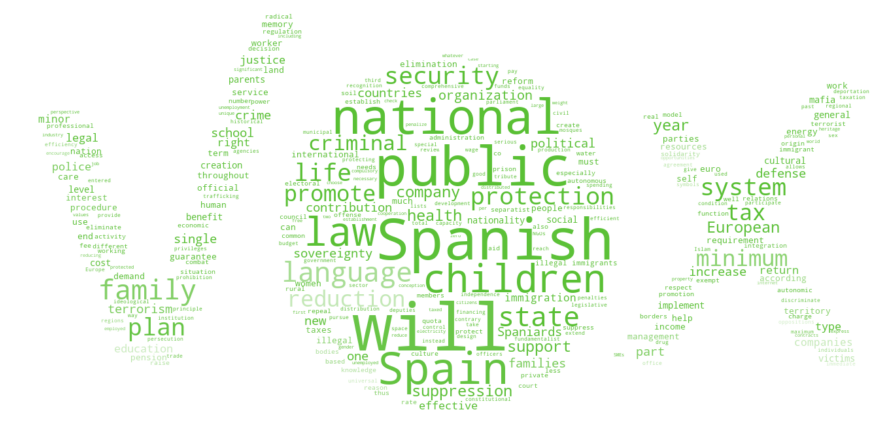

In [16]:
translator = Translator()
raw_txt = preprocess_raw_text(get_program('vox'))
en_txt = ' '.join([translator.translate(raw_txt[i:i+5000], src='es', dest='en').text
                   for i in range(0, len(raw_txt), 5000)])
                              
wc = generate_word_cloud(en_txt, 'vox', get_stop_words('en'))

With the following code we would obtain the relative weight of each word, from greater to lesser importance:

In [17]:
wc.words_

{'will': 1.0,
 'Spanish': 0.7407407407407407,
 'public': 0.6666666666666666,
 'national': 0.6296296296296297,
 'Spain': 0.5925925925925926,
 'law': 0.48148148148148145,
 'children': 0.4444444444444444,
 'language': 0.37037037037037035,
 'state': 0.37037037037037035,
 'family': 0.37037037037037035,
 'protection': 0.2962962962962963,
 'security': 0.2962962962962963,
 'plan': 0.2962962962962963,
 'system': 0.2962962962962963,
 'life': 0.2962962962962963,
 'reduction': 0.2962962962962963,
 'minimum': 0.2962962962962963,
 'tax': 0.2962962962962963,
 'promote': 0.2962962962962963,
 'criminal': 0.25925925925925924,
 'suppression': 0.25925925925925924,
 'health': 0.25925925925925924,
 'European': 0.25925925925925924,
 'company': 0.25925925925925924,
 'year': 0.25925925925925924,
 'support': 0.25925925925925924,
 'organization': 0.25925925925925924,
 'sovereignty': 0.2222222222222222,
 'Spaniards': 0.2222222222222222,
 'single': 0.2222222222222222,
 'contribution': 0.2222222222222222,
 'politic

After several tests and checks with this mode and the original electoral programs, we chose to use another variant, to control the process a little more and not getting weird things...

## Word clouds by frequency

Let's create word clouds without leaving everything in hands of the word_cloud library. For each electoral program we'll first create a dictionary with all the words and the number of appearances of each one, so we can use it later in our analysis.

Additionally, we'll print the number of appearances of the 50 most frequent words in each electoral program.

NOTE: At this point we eliminate punctuation marks (to avoid for example processing words that include periods or commas). We also remove words with less than 3 characters.

In [18]:
# Punctuation signs
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
def get_frequency_dict(input_txt):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # Missing '+'? expecting 'I+D'...
    clr_txt = input_txt.translate(str.maketrans('!"#$%&\'()*,-./:;<=>?@[\\]^_`{|}~',
                                                '                               '))
    # making dict for counting frequencies
    for word in clr_txt.split(' '):
        if word not in stopwords and len(word) > 2:
            tmpDict[word] = tmpDict.get(word, 0) + 1

    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    
    return fullTermsDict

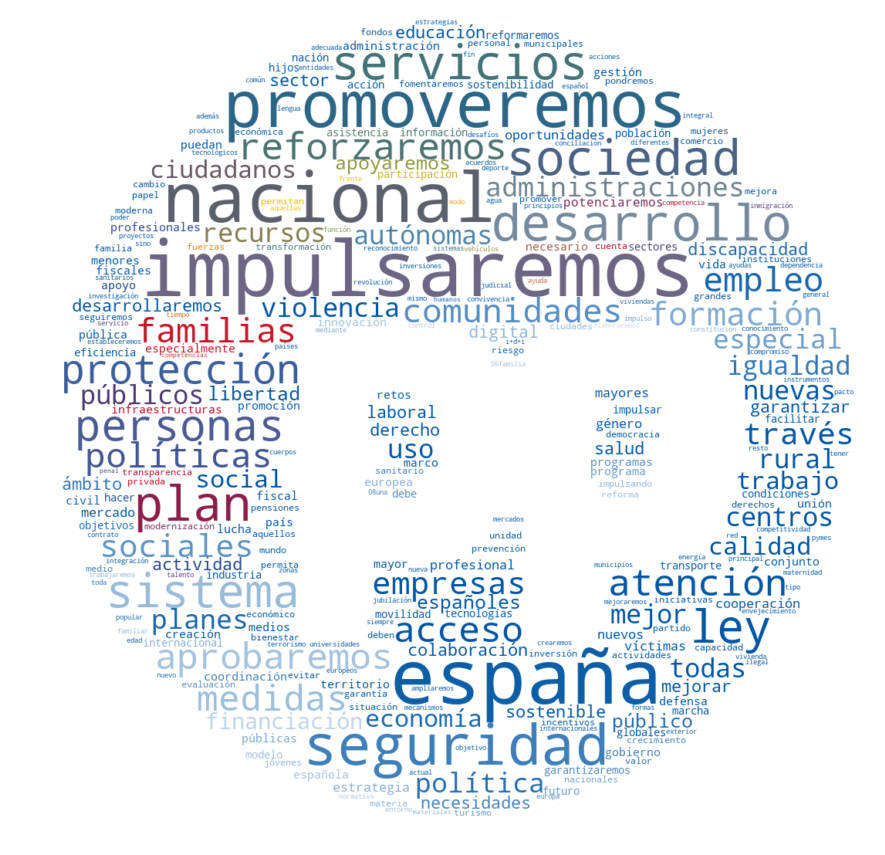

PP
impulsaremos: 95 | españa: 94 | nacional: 76 | promoveremos: 76 | seguridad: 71 | desarrollo: 64 | sociedad: 60 | plan: 60 | servicios: 58 | sistema: 55 | ley: 54 | personas: 49 | protección: 49 | reforzaremos: 47 | atención: 47 | aprobaremos: 46 | acceso: 46 | medidas: 44 | políticas: 44 | empleo: 43 | familias: 43 | comunidades: 42 | formación: 41 | empresas: 40 | sociales: 40 | través: 39 | administraciones: 39 | política: 38 | especial: 38 | planes: 38 | públicos: 37 | recursos: 37 | uso: 37 | centros: 37 | igualdad: 36 | autónomas: 36 | nuevas: 35 | mejor: 34 | rural: 34 | todas: 34 | violencia: 34 | ciudadanos: 33 | calidad: 32 | social: 32 | economía: 32 | trabajo: 31 | financiación: 31 | apoyaremos: 31 | españoles: 30 | libertad: 30 | 

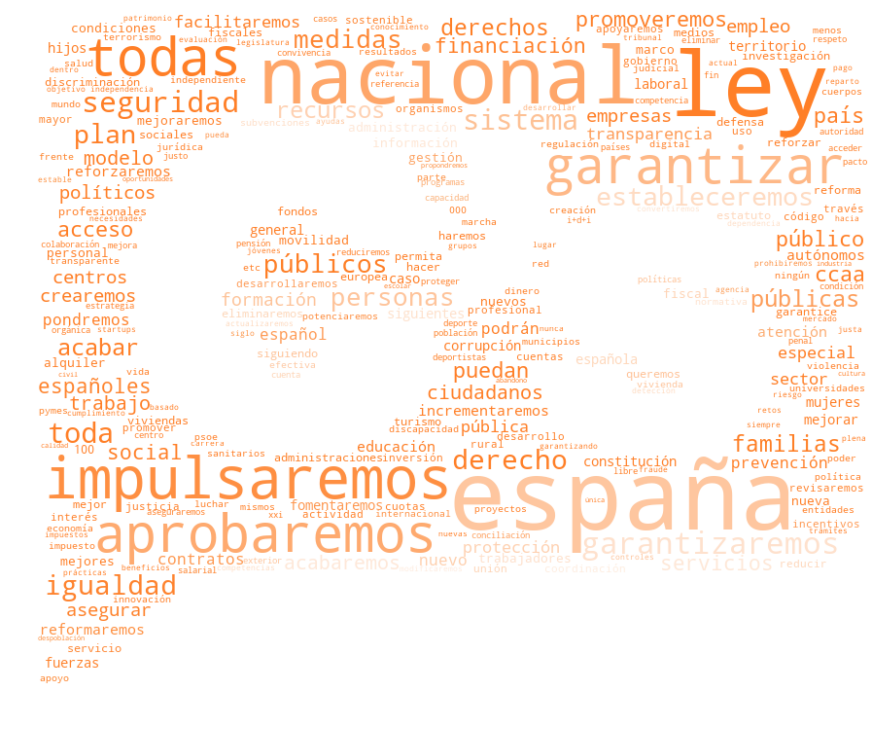

CIUDADANOS
españa: 72 | ley: 60 | nacional: 47 | impulsaremos: 39 | aprobaremos: 35 | todas: 35 | garantizar: 33 | garantizaremos: 30 | seguridad: 29 | toda: 28 | sistema: 28 | igualdad: 27 | derecho: 27 | estableceremos: 26 | plan: 26 | públicos: 25 | medidas: 25 | personas: 25 | públicas: 22 | recursos: 22 | acabar: 22 | derechos: 21 | familias: 21 | público: 20 | puedan: 20 | ccaa: 20 | acceso: 20 | país: 20 | promoveremos: 20 | financiación: 19 | españoles: 19 | servicios: 19 | social: 19 | ciudadanos: 18 | modelo: 18 | acabaremos: 18 | trabajo: 18 | asegurar: 17 | políticos: 17 | empleo: 17 | crearemos: 17 | empresas: 17 | centros: 17 | formación: 16 | pública: 15 | transparencia: 15 | protección: 15 | sector: 15 | especial: 15 | facilitaremos: 15 | 

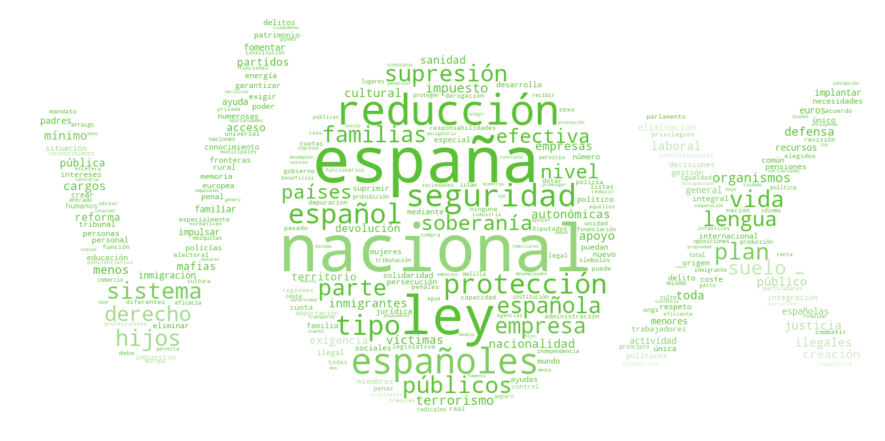

VOX
nacional: 16 | españa: 15 | ley: 10 | reducción: 9 | españoles: 8 | seguridad: 8 | protección: 7 | español: 7 | tipo: 7 | supresión: 7 | plan: 7 | sistema: 7 | parte: 7 | públicos: 7 | vida: 7 | española: 7 | empresa: 7 | familias: 7 | hijos: 7 | soberanía: 6 | lengua: 6 | derecho: 6 | efectiva: 6 | países: 6 | nivel: 6 | suelo: 6 | organismos: 6 | impuesto: 6 | terrorismo: 6 | menos: 5 | autonómicas: 5 | toda: 5 | justicia: 5 | cargos: 5 | inmigrantes: 5 | ilegales: 5 | empresas: 5 | nacionalidad: 5 | víctimas: 5 | defensa: 5 | público: 5 | mínimo: 5 | apoyo: 5 | laboral: 5 | creación: 5 | cultural: 5 | partidos: 4 | acceso: 4 | pública: 4 | devolución: 4 | 

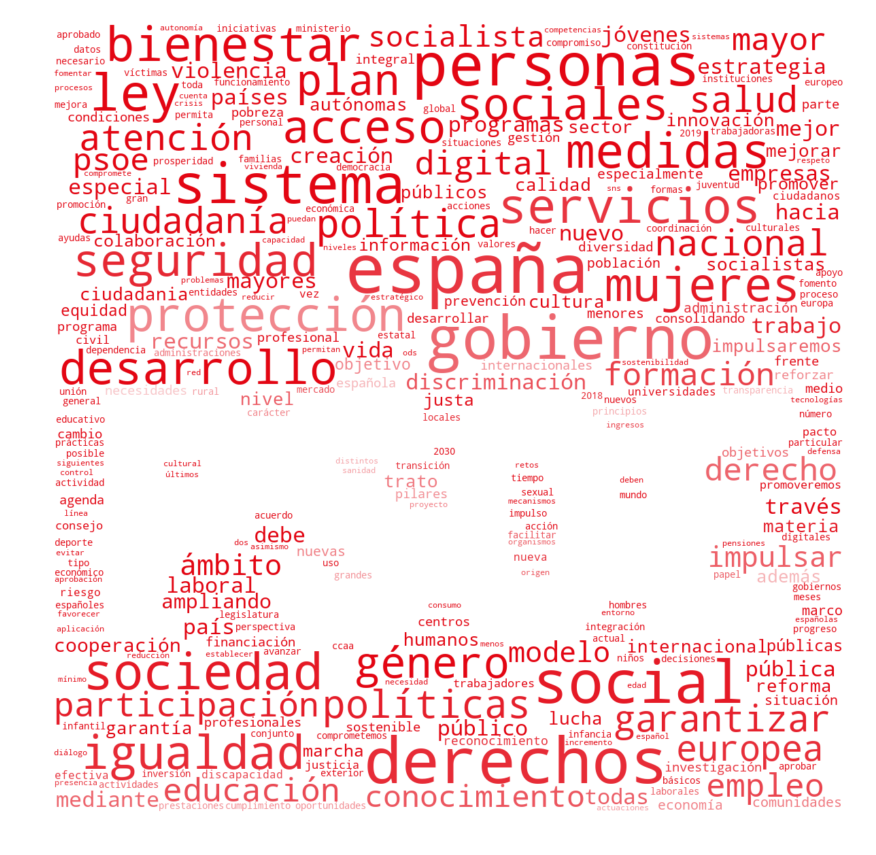

PSOE
españa: 242 | derechos: 212 | gobierno: 186 | personas: 184 | social: 179 | sistema: 156 | ley: 133 | sociedad: 130 | medidas: 120 | servicios: 120 | bienestar: 118 | igualdad: 116 | protección: 116 | mujeres: 115 | desarrollo: 111 | acceso: 109 | seguridad: 106 | sociales: 103 | género: 97 | plan: 97 | políticas: 95 | política: 94 | garantizar: 94 | nacional: 90 | atención: 89 | salud: 88 | ciudadanía: 85 | europea: 84 | participación: 82 | digital: 79 | empleo: 77 | educación: 77 | formación: 75 | psoe: 74 | mayor: 73 | derecho: 72 | conocimiento: 72 | socialista: 71 | impulsar: 69 | ámbito: 68 | modelo: 67 | discriminación: 67 | hacia: 65 | empresas: 64 | creación: 64 | vida: 63 | todas: 62 | trabajo: 62 | jóvenes: 61 | violencia: 61 | 

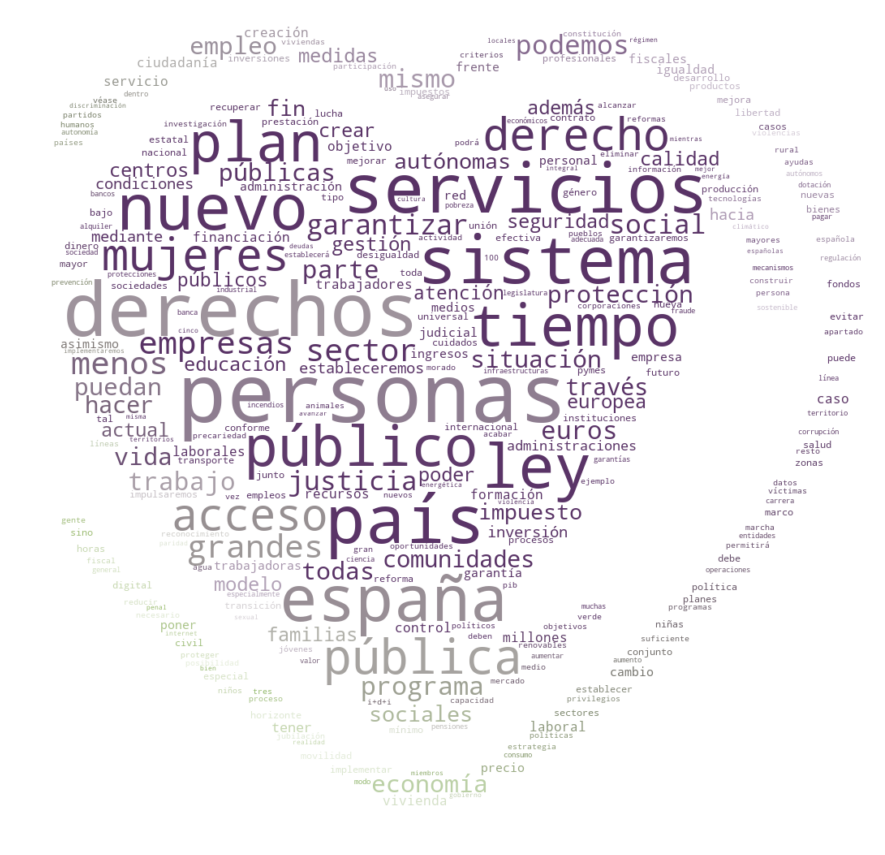

UNIDAS_PODEMOS
personas: 93 | derechos: 78 | servicios: 64 | país: 61 | sistema: 60 | nuevo: 56 | españa: 56 | ley: 52 | tiempo: 47 | público: 44 | plan: 43 | pública: 42 | mujeres: 41 | derecho: 41 | acceso: 40 | empresas: 40 | grandes: 39 | menos: 39 | sector: 38 | garantizar: 38 | podemos: 36 | justicia: 36 | social: 36 | mismo: 34 | programa: 34 | parte: 31 | euros: 31 | trabajo: 31 | empleo: 30 | situación: 30 | puedan: 30 | protección: 30 | vida: 29 | todas: 29 | economía: 29 | públicas: 29 | través: 28 | comunidades: 28 | hacer: 28 | impuesto: 28 | fin: 27 | sociales: 27 | autónomas: 27 | seguridad: 27 | modelo: 26 | poder: 26 | actual: 26 | europea: 26 | educación: 26 | medidas: 25 | 

In [20]:
freq_dicts = {}
wcs = {}

for party in parties:
    
    # Generate frequencies dict
    freq_dicts[party] = get_frequency_dict(programs_dict[party])

    # Generate word cloud. NOTE: neither bigrams nor normalization with this approach
    wcs[party] = generate_word_cloud(freq_dicts[party], party, stopwords)
    
    # Print Top 50 words with frequency
    print(party.upper())
    for key in sorted(freq_dicts[party], key=freq_dicts[party].get, reverse=True)[:50]:
        print('{}: {}'.format(key, freq_dicts[party][key]), end=' | ')
    

With this, we get an idea of the most important topics in each program. It's very interesting :)

*NOTE: a detailed analysis is done in the spanish version of this notebook. *

And what about those words we miss? Let's try to answer that question in the next point.

# Concerns of the spanish voters

What is the purpose of the political parties? That's a good question. Supposedly, parties try to represent as many citizens as possible, and in theory, the electoral programs should try to collect solutions to the most important problems, or the biggest concerns of the average voter.

The **CIS** (Sociological Researching Center) conducts a monthly survey where they ask a small sample of the population which are the 3 most worrisome problems. That helps us to get an idea of the general feeling. It seems a good starting point....

We'll try to find out if the priority given to these issues by the electoral programs corresponds to the importance the voters give them.

## CIS survey

We load the data of the last survey:

In [21]:
cis_df = parse_cis_excel()

We draw an interactive graph of horizontal bars to clearly visualize the data, using `plotly_express`:

In [22]:
px.bar(
    cis_df, x="concern", y="problem", template="plotly_white",
    labels=dict(concern="% of respondents for whom the problem is Top 3", problem="Problem"),
    width=970, height=800, title="Main (3) concerns of spanish people [March 2019]",
    orientation='h'
)

Unemployment, corruption, fraud, political parties, economy, health, education, .... Although we could expect such a list, it's always important to know the figures. According to the data, only the top 18 problems exceed 1% of people who place them in their personal Top 3. Although it's clear that the environment worries more than 0.8% of the population, right?

There is a lot of difference between the first problem and the second; or between the first four and all the others. Well, let's see what the electoral programs say...

## Reflection in the electoral programs

We will create a dictionary with an entry for each `(*)` of the main problems according to the CIS survey. And for each entry, we'll make a list with some of the most significant words that we would expect to find related to the issue of the matter in question.

This part is the most delicate one, because there are words that could be related to several topics, and its inclusion in one list or in another (or none) should be assessed.

`(*)` NOTE: some topics have been joined, such as *Catalonia* and the *nationalisms*, *unemployment* and *quality of employment*, or *political* and *instability*. Others have been separated, such as *fraud* and *corruption* (why is CIS joining them?). *International terrorism* has become *terrorism* in general.

In [23]:
problems = {'employment': ['paro', 'paradas', 'parados', 'parada', 'parado', 'empleo', 'desempleado',
                       'desempleada', 'desempleados', 'desempleo', 'laboral', 'laborales', 'salario'],
            'corruption': ['corrupción', 'corrupto', 'corrupta', 'corruptos', 'corruptas', 
                           'imputados', 'imputado'],
            'fraud': ['fraude', 'defraudan', 'defraudar', 'defraudado', 'defraudador', 'defraudadores'],
            'políticians': ['regeneración', 'pacto', 'pactos', 'consenso', 'diálogo', 'casta',
                          'inestabilidad', 'acuerdos', 'desacuerdos'],
            'economy': ['economía', 'pib', 'económica', 'crisis', 'mercado', 'euro', 'económico',
                         'crecimiento'],
            'healthcare': ['sanidad', 'médico', 'médicos', 'quirófano', 'hospital', 'sanitarios', 
                        'sanitarias', 'sanitaria', 'medicamentos'],
            'education': ['educación', 'enseñanza', 'escuela', 'idiomas', 'profesores', 'guardería',
                          'guarderías', 'universidad', 'universidades'],
            'nationalisms': ['cataluña', 'catalanes', 'referéndum', '155', 'independencia', 'independentistas', 
                         'nacionalismo', 'nacionalismos', 'separatistas', 'separatismo', 'soberanía'],
            'social': ['social', 'equitativa', 'equitativo', 'sociales', 'pobreza'],
            'pensions': ['pensiones', 'pensión', 'jubilación', 'pensionistas', 'pensionista', 'jubilado', 
                          'jubilados', 'jubiladas'],
            'inmigration': ['inmigración', 'inmigrante', 'inmigrantes', 'extranjero', 'extranjeros', 
                            'refugiados', 'refugiado', 'cie', 'salvamento', 'frontera', 'ceuta'],
            'gender violence': ['machista', 'machistas', 'acoso', 'violación', 'violada', 'violadas', 
                                   'violaciones', 'maltrato', 'maltratada', 'maltratadas'],
            'insecurity': ['inseguridad', 'ciberataques', 'ciberseguridad', 'policía', 'violentos', 
                            'crímenes', 'robos'],
            'housing': ['vivienda', 'alquiler', 'alquileres', 'hipoteca', 'hipotecas', 'especulación', 
                         'especuladores', 'buitre', 'buitres', 'desahucio', 'desahucios', 'okupa', 'okupas'],
            'justice': ['justicia', 'jueces', 'juez', 'juicio', 'juicios', 'sentencia', 'prisión', 
                         'cárcel', 'tribunal', 'tribunales'],
            'values': ['valores', 'familia', 'aborto', 'tradiciones', 'tradición'],
            'woman': ['mujer', 'mujeres', 'feminismo', 'feminismos', 'paridad'],
            'environment': ['medioambiente', 'medioambiental', 'planeta', 'contaminación', 'contaminantes', 
                              'reciclar', 'renovables', 'climático', 'ambiental', 'ambientales'],
            'young people': ['juvenil', 'juventud', 'jóvenes', 'emancipación'],
            'infraestructure': ['infraestructura', 'infraestructuras', 'carreteras', 'trenes', 
                                 'ave', 'ferroviaria', 'ferroviarias', 'puentes', 'autopistas', 
                                 'carretera'],
            'taxes': ['impuestos', 'impuesto', 'iva', 'irpf', 'sucesiones', 'gravamen'],
            'investment': ['i+d', 'i+d+i', 'inversión', 'inversiones', 'invertir', 'invierte', 'investigación',
                          'investigadores'],
            'monarchy': ['monarquía', 'reyes', 'república', 'rey', 'monarca', 'republicanos'],
            'self-employed': ['autónomos', 'emprendedores', 'emprendedor'],
            'racism': ['racismo', 'racista', 'racistas', 'xenofobia', 'xenófobo', 'xenófobos'],
            'drugs': ['droga', 'drogas', 'heroína', 'cocaína', 'adicción', 'adicciones'],
            'husbandry, fishing': ['agrario', 'agraria', 'agricultura', 'agricultor', 'agricultores', 
                                  'ganadería', 'ganadero', 'ganaderos', 'pesca', 'pescadores', 'pescador',
                                  'agropecuario', 'agrícola', 'agrícolas'],
            'terrorism': ['terrorismo', 'terrorista', 'terroristas', 'isis', 'eta', 'etarra', 'islamista',
                           'islamistas', 'atentado', 'atentados', 'etarras']
            }

We'll count the number of words in each electoral program (dropped stop and short words). Apart from counting the number of occurrences of words related to each problem, we're interested in knowing their frequency; so we can see the relative importance within each program, and we can also make a valid comparison between all.

In [24]:
program_words = {party: sum(freq_dicts[party].values()) for party in parties}  
program_words

{'pp': 14499,
 'ciudadanos': 7479,
 'vox': 1824,
 'psoe': 33127,
 'unidas_podemos': 14811}

We create a dataframe with the counting of words associated with each problem, for each party:

In [25]:
def build_problems_df(problems):
    df = pd.DataFrame(columns=problems.keys(), dtype=int)

    for party in parties:
        counts_array = []
        for problem in problems.keys():
            counts = 0
            for word in problems.get(problem):
                counts += freq_dicts[party].get(word, 0)
            counts_array.append(counts)
        df.loc[party] = counts_array

    df['TOTAL'] = program_words.values()
    return df

In [26]:
df = build_problems_df(problems)

Let's paint the contents of the dataframe using the `heatmap ()` function of `seaborn`:

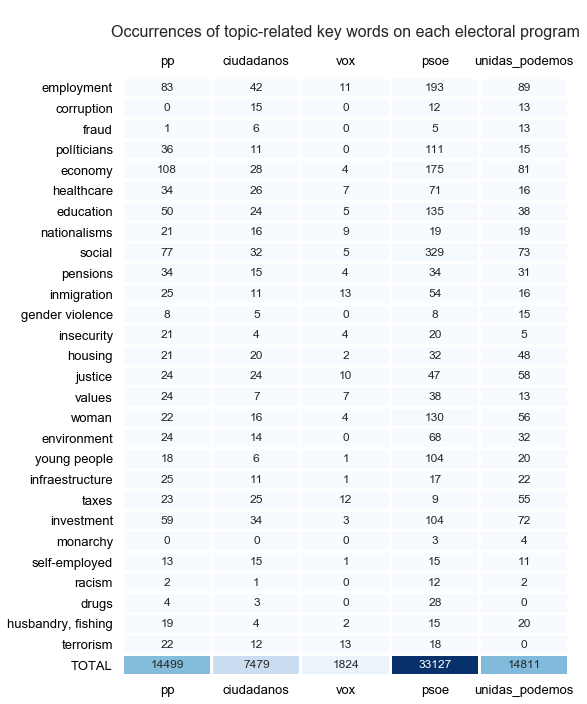

In [27]:
plt.figure(figsize=(8,11))
ax = sns.heatmap(df.T, annot=True, fmt='d', cmap='Blues', cbar=False, linecolor='white', linewidths=2)

ax.tick_params(labelbottom=True, labeltop=True, labelsize=13, labelcolor='black')
ax.set_title('\nOccurrences of topic-related key words on each electoral program\n\n', 
             fontsize=16);

Some interesting points:

* Second concern of the spaniards, face A: **corruption**. The most striking thing is that PP's program doesn't use any of these words related to 'corruption'. In almost 15,000 words it seems that there was no place for the *leaders of political regeneration* to touch the subject; it's curious when they supposedly want to break with what has made them lose tons of votes. Neither does corruption appear in Vox's program, which is even more worrying in the case of a new party.

* Second concern, face B: **fraud**. PP's program uses one of these words only once: 'fraud', 'defraud', 'defrauded', 'fraudster', 'fraudsters'. If you go to the program this is all you will find on the subject: *'We will strengthen the policies of fight against tax fraud, promoting the use of human and technological means'*. Vox says nothing. Bravo!

* The **Vox program** seems not to mention other important concerns. For example: violence against women. And nothing related to environment. We already knew that it wasn't an usual electoral program, but....

After looking a little over the anomalies (and making sure that our code has no errors), we'll move from number of appearances to frequency, in order to analyze the results better. We create another dataframe by dividing that number of occurrences by the total number of words in each program (and multiplying by 100 to obtain percentages):

In [28]:
df_rel = df.div(0.01*df['TOTAL'], axis=0).drop('TOTAL', axis=1)

Again we use the heatmap in `seaborn` to represent the content of the dataframe:

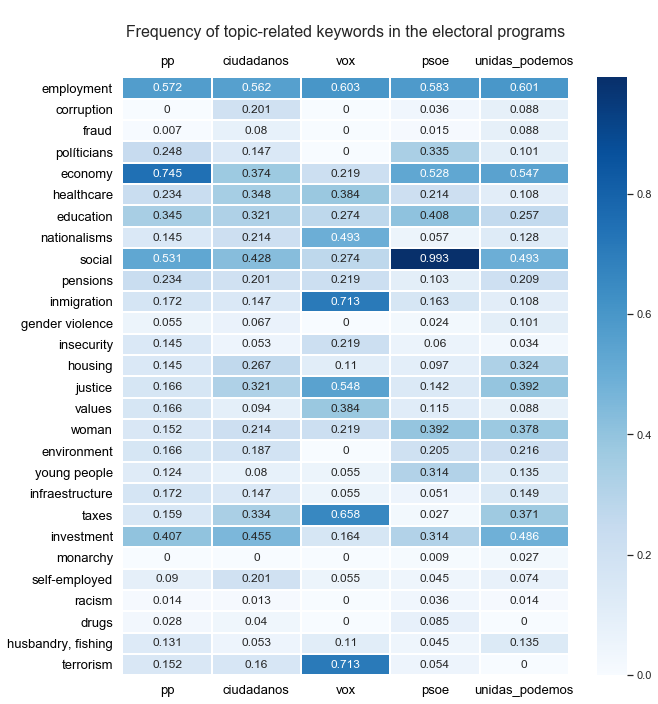

In [29]:
plt.figure(figsize=(10,11))
ax = sns.heatmap(df_rel.T.round(3), annot=True, fmt='g', cmap='Blues', linecolor='white', linewidths=1)

ax.tick_params(labelbottom=True, labeltop=True, labelsize=13, labelcolor='black')
ax.set_title('\nFrequency of topic-related keywords in the electoral programs\n\n', 
             fontsize=16);

We'll create a horizontal bar chart grouped by subject, in order to see the weight of each problem, and simultaneously compare the 5 parties on each of them (something made possible by the previous normalization). The order of the problems comes from the importance reflected in the CIS survey (from lowest to highest). What we would expect to find is that the size of the bars would grow as we go forward, although by seeing the dataframe we already know that won't be fulfilled.

We use the `plot()` function of `pandas`:

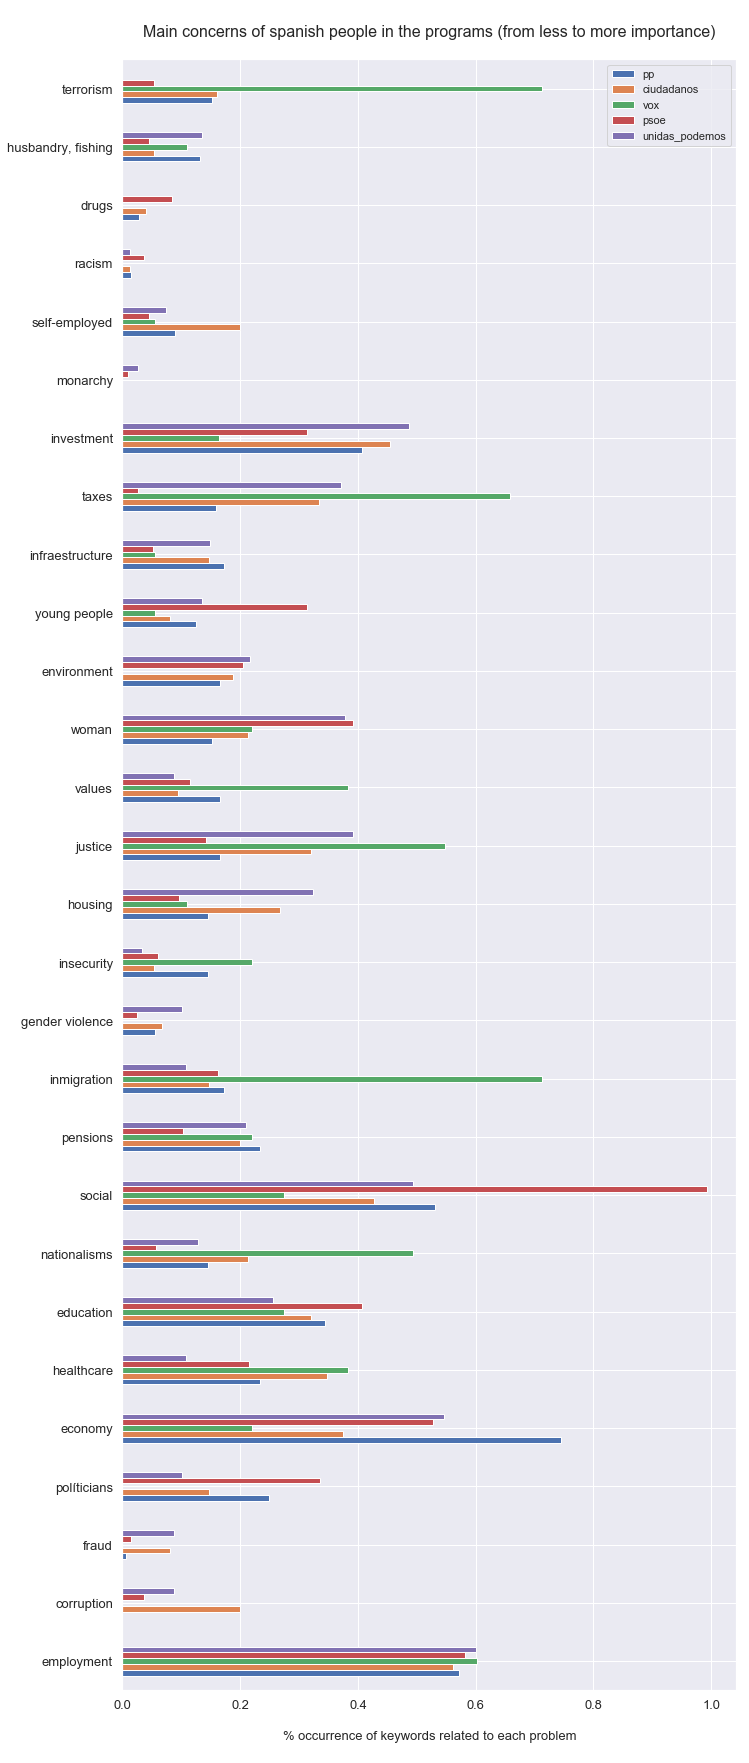

In [30]:
ax = df_rel.T.plot(kind='barh', figsize=(11,30), fontsize=13)

ax.set_title('\nMain concerns of spanish people in the programs (from less to more importance)\n', 
             fontsize=16)
ax.set_xlabel("\n% occurrence of keywords related to each problem\n", fontsize=13);

It doesn't seem to follow the pattern of voter concerns, especially in matter of corruption and fraud (2nd position); where only the programs of Ciudadanos and Unidas Podemos seem to have an impact. The rest goes on tiptoe or directly does not go (if curiosity tightens, you should go directly to the programs).

We can observe something else:
* From the comparison between parties we see that Vox's program is the most different from the rest, by far.
* PSOE seems to have put a lot of emphasis on social issues, in addition to aligning with women and young people.
* Ciudadanos is the party that focuses more on the self-employed.
* Unidas Podemos is the one that dedicates more of its program to investments, housing, the agricultural sector, or the environment.
* The PP's program only stands out, and not much, in terms of economy and infrastructure.

Maybe after this brief analysis we won't know the measures each program explains, but it has helped us to know what program we don't even need to open.

An electoral program is the place where each party should tell all its intentions, although it seems that programs are losing importance (from both sides).

# More problems!

Another exercise we can do is to look for specific issues that really concern the population although they don't appear in the CIS surveys:

In [31]:
problems = {'rural': ['rural', 'rurales', 'despoblación'],
            'culture': ['cultura', 'cine', 'música', 'teatro'],
            'lgbt': ['lgtb', 'lgtbi', 'lesbianas', 'homosexuales', 'homosexual', 'transgénero', 'gay', 
                      'gays', 'homofobia'],
            'animals': ['animales', 'animalista', 'animalistas', 'mascotas'],
            'bullfighting': ['tauromaquia', 'toro', 'toros', 'taurino', 'taurinos', 'corrida', 'corridas'],
            'Church': ['iglesia', 'católicos', 'católica', 'católico', 'cristianos', 'cristiano',
                        'cristiandad', 'sectas', 'procesiones'],
            'euthanasia': ['eutanasia'],
            'NGO': ['ong', 'ongs'],
            'abortion': ['aborto', 'abortar']
            }

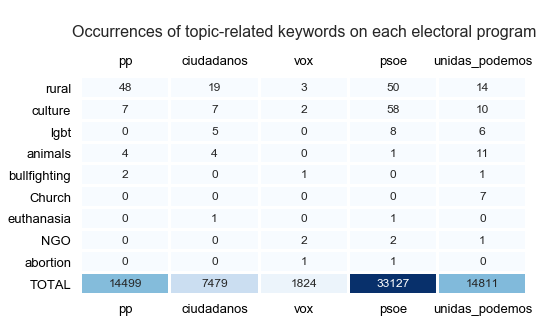

In [32]:
df = build_problems_df(problems)

plt.figure(figsize=(8,4))
ax = sns.heatmap(df.T, annot=True, fmt='d', cmap='Blues', cbar=False, linecolor='white', linewidths=2)

ax.tick_params(labelbottom=True, labeltop=True, labelsize=13, labelcolor='black')
ax.set_title('\nOccurrences of topic-related keywords on each electoral program\n\n', 
             fontsize=16);

Some interesting points:
* Problems of the rural world seem to be important for all parties (thank goodness).
* PP and Vox seem not to make any reference to the LGBT collective.
* The program of Unidas Podemos seems to be the only one that talks about the Church.

Here we could invest a lot of time :)

# Future lines of work

This analysis could be expanded in several directions:
* Comparison with the electoral programs of the previous general election, to see how they evolved.
* Sentiment analysis. We don't know if a certain topic is discussed in one direction or the opposite.
* Use of bigrams and trigrams to make a better study of the programs.
* Analysis of electoral speeches.
* Creation of an API to search over the programs

P.D.- It is a pity that electoral programs are published so late and there is not time for much more. For the next election we'll be prepared in advance!

# References
* [tika-python](https://github.com/chrismattmann/tika-python)
* [pdftotext](https://en.wikipedia.org/wiki/Pdftotext)
* [textract](https://textract.readthedocs.io/en/latest/)
* [beautiful soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
* [stop-words](https://pypi.org/project/stop-words/)
* [word_cloud](https://amueller.github.io/word_cloud/)
* [googletrans](https://py-googletrans.readthedocs.io/en/latest/)
* [plotly_express](https://medium.com/@plotlygraphs/introducing-plotly-express-808df010143d)
* [seaborn](https://seaborn.pydata.org/)
* [pandas visualization](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)